In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [118]:
df = pd.read_csv('bank-full.csv', sep=';', quotechar='"')

In [119]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [120]:
df.shape

(45211, 17)

In [121]:
df = df.rename(columns = {"y":"subscribed"})

In [122]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [136]:
df.month.value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         45211 non-null  int64 
 1   job         45211 non-null  object
 2   marital     45211 non-null  object
 3   education   45211 non-null  object
 4   default     45211 non-null  object
 5   balance     45211 non-null  int64 
 6   housing     45211 non-null  object
 7   loan        45211 non-null  object
 8   contact     45211 non-null  object
 9   day         45211 non-null  int64 
 10  month       45211 non-null  object
 11  duration    45211 non-null  int64 
 12  campaign    45211 non-null  int64 
 13  pdays       45211 non-null  int64 
 14  previous    45211 non-null  int64 
 15  poutcome    45211 non-null  object
 16  subscribed  45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [124]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [125]:
df.isnull().sum().sort_values(ascending=False)

age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
balance       0
default       0
education     0
marital       0
subscribed    0
dtype: int64

### EDA

### Univariate Analysis

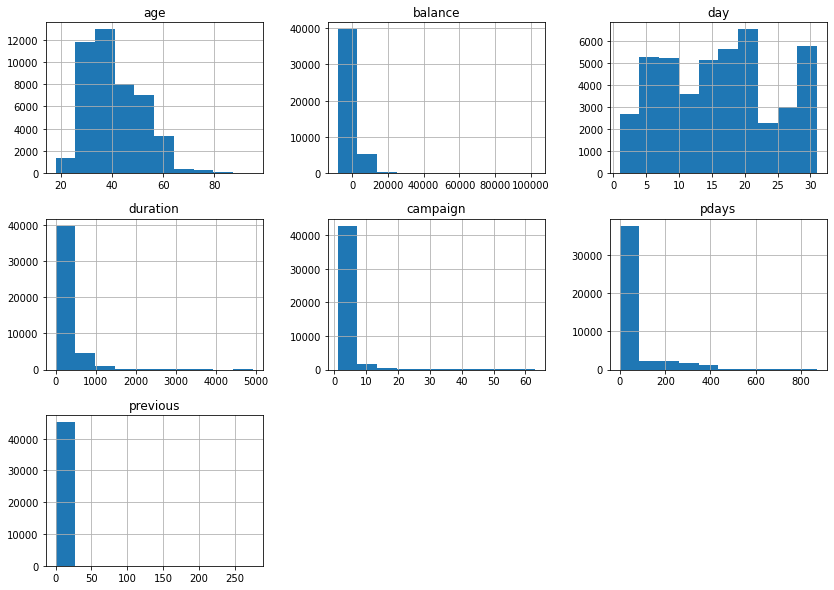

In [126]:
df.hist(figsize=(14, 10))
plt.show()

### Correlation Heatmap

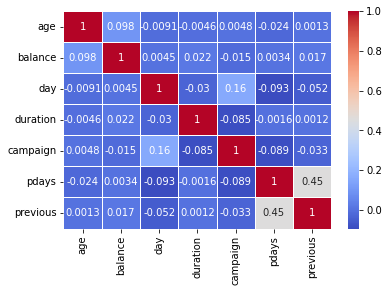

In [127]:
num_col = df.select_dtypes(include=[np.number]).columns.tolist()
correlation = df[num_col].corr()

sns.heatmap(correlation, cmap='coolwarm', annot=True, linewidth=.5)
plt.show()

In [128]:
len (df[df['pdays'] > 400] ) / len(df) * 100

0.5175731569750724

In [129]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.059719979650969895

In [130]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.024330362080024773

<AxesSubplot:title={'center':'subscribed value counts'}>

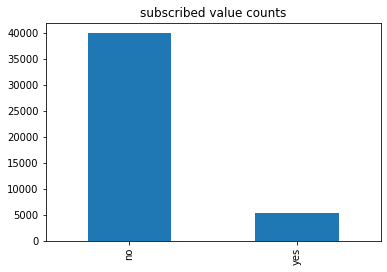

In [138]:
value_counts = df['subscribed'].value_counts()

value_counts.plot.bar(title = 'subscribed value counts')

In [132]:
df['subscribed'].value_counts()

no     39922
yes     5289
Name: subscribed, dtype: int64

In [86]:
# there is a class imbalance in the dataset

### using SMOTE to fix the class imbalance

In [87]:
X = df.drop('subscribed', axis=1)
y = df['subscribed']

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

le_dict = {}

X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

df_balanced_smote = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced_smote['subscribed'] = y_resampled

for col in categorical_cols:
    unique_values = np.unique(df_balanced_smote[col])
    le = le_dict[col]
    
    if len(unique_values) > len(le.classes_):
        le.classes_ = np.concatenate([le.classes_, unique_values[len(le.classes_):]])
    
    df_balanced_smote[col] = le.inverse_transform(df_balanced_smote[col].astype(int))

for col in numeric_cols:
    df_balanced_smote[col] = df_balanced_smote[col].astype(X[col].dtype)

In [88]:
print(df_balanced_smote['subscribed'].value_counts())

no     39922
yes    39922
Name: subscribed, dtype: int64


In [141]:
df_balanced_smote.shape

(78896, 17)

<AxesSubplot:title={'center':'subscribed value counts'}>

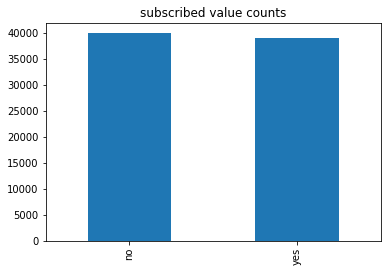

In [142]:
value_counts = df_balanced_smote['subscribed'].value_counts()

value_counts.plot.bar(title = 'subscribed value counts')

### Bivariate Analysis

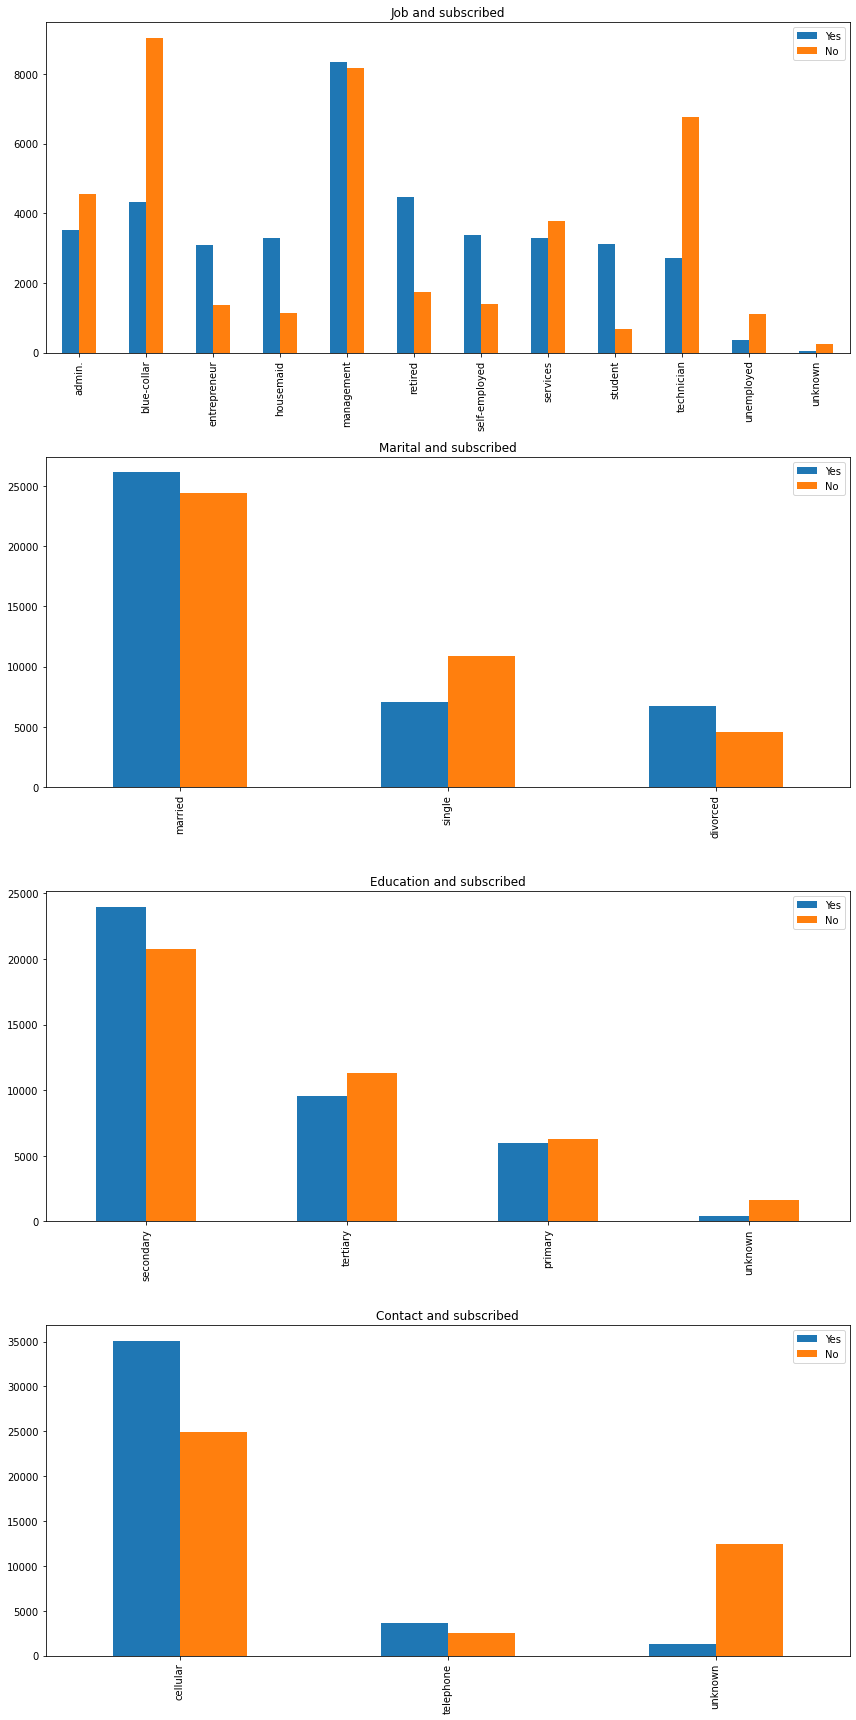

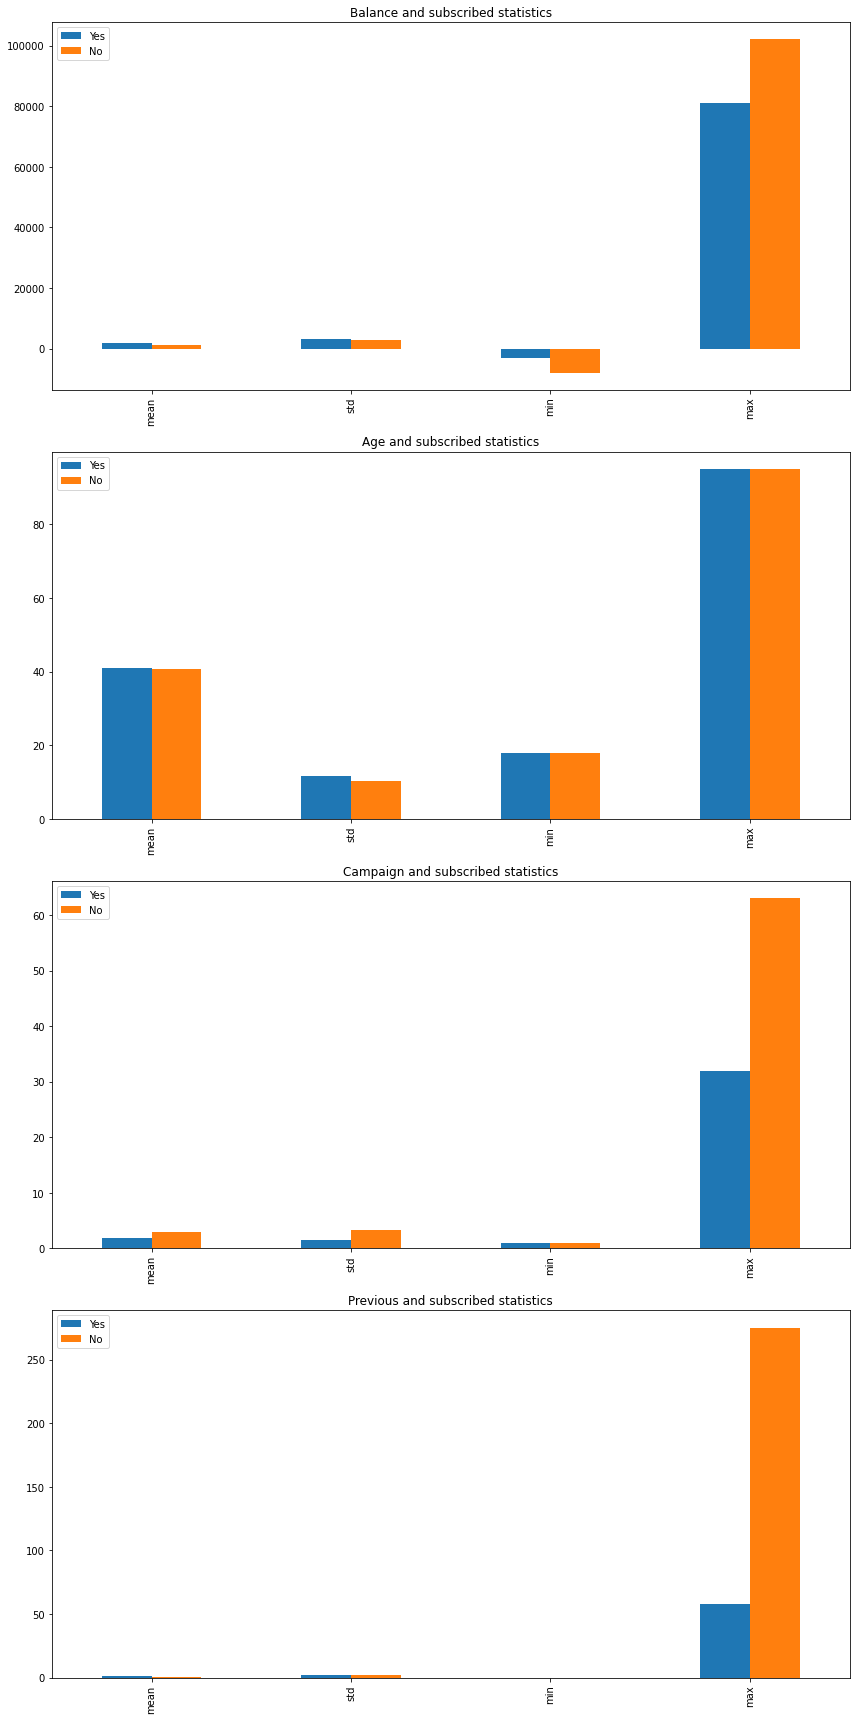


Balance statistics:
        balance_yes     balance_no
count  39922.000000   39922.000000
mean    1793.025099    1303.714969
std     3342.348950    2974.195473
min    -3058.000000   -8019.000000
25%      210.000000      58.000000
50%      727.000000     417.000000
75%     2144.000000    1345.000000
max    81204.000000  102127.000000

Age statistics:
            age_yes        age_no
count  39922.000000  39922.000000
mean      40.962151     40.838986
std       11.642483     10.172662
min       18.000000     18.000000
25%       32.000000     33.000000
50%       38.000000     39.000000
75%       48.000000     48.000000
max       95.000000     95.000000

Campaign statistics:
       campaign_yes   campaign_no
count  39922.000000  39922.000000
mean       1.853915      2.846350
std        1.548802      3.212767
min        1.000000      1.000000
25%        1.000000      1.000000
50%        1.000000      2.000000
75%        2.000000      3.000000
max       32.000000     63.000000

Previous sta

In [89]:
def plot_categorical(df, columns, target='subscribed'):
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 6*len(columns)))
    for i, col in enumerate(columns):
        j_df = pd.DataFrame({
            'yes': df[df[target] == 'yes'][col].value_counts(),
            'no': df[df[target] == 'no'][col].value_counts()
        })
        j_df.plot(kind='bar', ax=axes[i] if len(columns) > 1 else axes)
        axes[i].set_title(f'{col.capitalize()} and {target}')
        axes[i].legend(['Yes', 'No'])
    plt.tight_layout()
    plt.show()

def plot_numerical(df, columns, target='subscribed'):
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 6*len(columns)))
    for i, col in enumerate(columns):
        n_df = pd.DataFrame({
            f'{col}_yes': df[df[target] == 'yes'][col].describe(),
            f'{col}_no': df[df[target] == 'no'][col].describe()
        })
        n_df.drop(['count', '25%', '50%', '75%']).plot(kind='bar', ax=axes[i] if len(columns) > 1 else axes)
        axes[i].set_title(f'{col.capitalize()} and {target} statistics')
        axes[i].legend(['Yes', 'No'])
    plt.tight_layout()
    plt.show()

categorical_columns = ['job', 'marital', 'education', 'contact']
plot_categorical(df_balanced_smote, categorical_columns)

numerical_columns = ['balance', 'age', 'campaign', 'previous']
plot_numerical(df_balanced_smote, numerical_columns)

for col in numerical_columns:
    print(f"\n{col.capitalize()} statistics:")
    n_df = pd.DataFrame({
        f'{col}_yes': df_balanced_smote[df_balanced_smote['subscribed'] == 'yes'][col].describe(),
        f'{col}_no': df_balanced_smote[df_balanced_smote['subscribed'] == 'no'][col].describe()
    })
    print(n_df)

In [90]:
dup = df_balanced_smote.duplicated().sum()
print(f'Number of duplicate rows: {dup}')

Number of duplicate rows: 948


In [91]:
df_balanced_smote = df_balanced_smote.drop_duplicates()

In [92]:
df_balanced_smote.shape

(78896, 17)

In [93]:
df_balanced_smote.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Detection of outliers

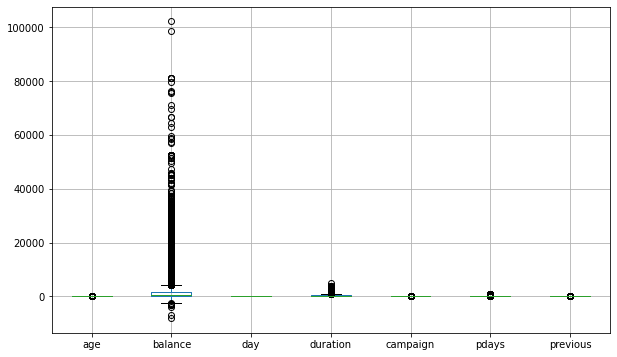

In [94]:
plt.figure(figsize=(10, 6))
df_balanced_smote.boxplot()
plt.show()

In [95]:
labels = ['Low', 'Medium', 'High', 'Very High']

df_balanced_smote['balance_category'] = pd.qcut(df_balanced_smote['balance'], 
                                       q=4, 
                                       labels=labels)
df_balanced_smote.drop('balance',axis=1,inplace=True)

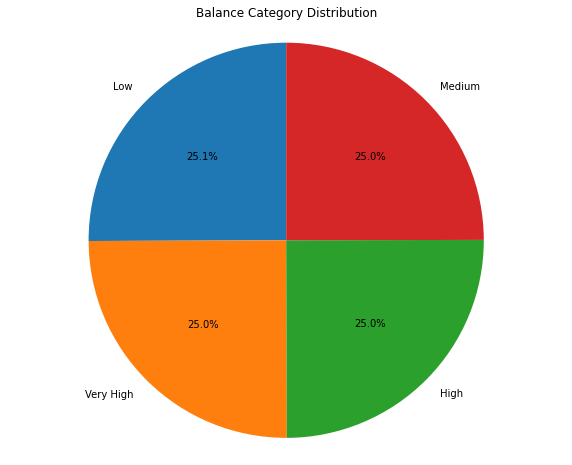

In [149]:
value_counts = df_balanced_smote['balance_category'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Balance Category Distribution')
plt.axis('equal') 
plt.show()

In [96]:
def categorize_pdays(pdays):
    if pdays == -1:
        return 'no_contact'
    elif pdays <= 7:
        return 'week'
    elif pdays <= 30:
        return 'month'
    elif pdays <= 90:
        return 'quarter'
    elif pdays <= 180:
        return 'half_year'
    else:
        return 'over_half_year'

df_balanced_smote['pdays_category'] = df_balanced_smote['pdays'].apply(categorize_pdays)

df_balanced_smote.drop('pdays',axis=1,inplace=True)

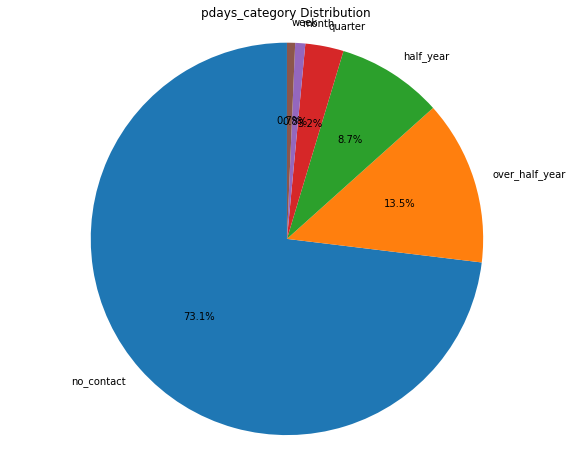

In [150]:
value_counts = df_balanced_smote['pdays_category'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('pdays_category Distribution')
plt.axis('equal') 
plt.show()

### Removing the outliers

In [97]:
numerical_columns = df_balanced_smote.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('subscribed') if 'subscribed' in numerical_columns else None

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers = pd.DataFrame()
for column in numerical_columns:
    column_outliers = detect_outliers(df_balanced_smote, column)
    outliers = pd.concat([outliers, column_outliers])

outliers = outliers.drop_duplicates()

df_clean = df_balanced_smote.drop(outliers.index)

print(f"Original dataset shape: {df_balanced_smote.shape}")
print(f"Number of outliers detected: {len(outliers)}")
print(f"Clean dataset shape: {df_clean.shape}")

Original dataset shape: (78896, 17)
Number of outliers detected: 16061
Clean dataset shape: (62835, 17)


In [98]:
df_clean.shape

(62835, 17)

In [99]:
df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,previous,poutcome,subscribed,balance_category,pdays_category
0,58,management,married,tertiary,no,yes,no,unknown,5,may,261,1,0,unknown,no,Very High,no_contact
1,44,technician,single,secondary,no,yes,no,unknown,5,may,151,1,0,unknown,no,Low,no_contact
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,76,1,0,unknown,no,Low,no_contact
3,47,blue-collar,married,unknown,no,yes,no,unknown,5,may,92,1,0,unknown,no,High,no_contact
4,33,unknown,single,unknown,no,no,no,unknown,5,may,198,1,0,unknown,no,Low,no_contact


### Converting categorical columns to numerical

In [100]:
categorical_columns = df_clean.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in ['default', 'housing', 'loan']:
    df_clean[col] = le.fit_transform(df_clean[col])

df_clean = pd.get_dummies(df_clean, columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome','balance_category', 'pdays_category'])

df_clean['day'] = pd.to_numeric(df_clean['day'])

In [101]:
df_clean['subscribed_num'] = df_clean['subscribed'].map({'no': 0, 'yes': 1})

### Preparing dataset

In [102]:
X = df_clean.drop(columns = ['subscribed_num','subscribed'])
y = df_clean[['subscribed_num']]

In [103]:
TEST_SIZE = 0.3
RAND_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

### Model Training

In [104]:
y = y.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    class_0_precision = report['0']['precision']
    class_0_recall = report['0']['recall']
    class_0_f1 = report['0']['f1-score']
    class_1_precision = report['1']['precision']
    class_1_recall = report['1']['recall']
    class_1_f1 = report['1']['f1-score']
    
    accuracy = report['accuracy']
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Class 0 Precision': class_0_precision,
        'Class 0 Recall': class_0_recall,
        'Class 0 F1': class_0_f1,
        'Class 1 Precision': class_1_precision,
        'Class 1 Recall': class_1_recall,
        'Class 1 F1': class_1_f1
    }

svc_model = SVC(kernel='rbf', random_state=42)
svc_results = train_and_evaluate(svc_model, X_train, X_test, y_train, y_test, "SVC")

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_results = train_and_evaluate(knn_model, X_train, X_test, y_train, y_test, "KNN")

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                              colsample_bytree=1, max_depth=7, random_state=42)
xgb_results = train_and_evaluate(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = train_and_evaluate(rf_model, X_train, X_test, y_train, y_test, "Random Forest")


SVC Results:
Accuracy: 0.7232

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      6732
           1       0.74      0.63      0.68      5835

    accuracy                           0.72     12567
   macro avg       0.73      0.72      0.72     12567
weighted avg       0.72      0.72      0.72     12567


KNN Results:
Accuracy: 0.8004

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6732
           1       0.77      0.80      0.79      5835

    accuracy                           0.80     12567
   macro avg       0.80      0.80      0.80     12567
weighted avg       0.80      0.80      0.80     12567


XGBoost Results:
Accuracy: 0.9154

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6732
           1       0.90      0.92      0.91      5835

    accuracy 

In [105]:
metrics_df = pd.DataFrame([svc_results, knn_results, xgb_results, rf_results])

In [106]:
metrics_df = metrics_df.round(2)

In [107]:
metrics_df

,Model,Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 1 Precision,Class 1 Recall,Class 1 F1
0,SVC,0.72,0.72,0.80,0.76,0.74,0.63,0.68
1,KNN,0.80,0.82,0.80,0.81,0.77,0.80,0.79
2,XGBoost,0.92,0.93,0.91,0.92,0.90,0.92,0.91
3,Random Forest,0.93,0.94,0.92,0.93,0.91,0.93,0.92


In [108]:
def get_top_features(model, feature_names, top_n=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        return None
    
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return feature_importance.head(top_n)

In [109]:
xgb_top_features = get_top_features(xgb_model, X.columns)
rf_top_features = get_top_features(rf_model, X.columns)

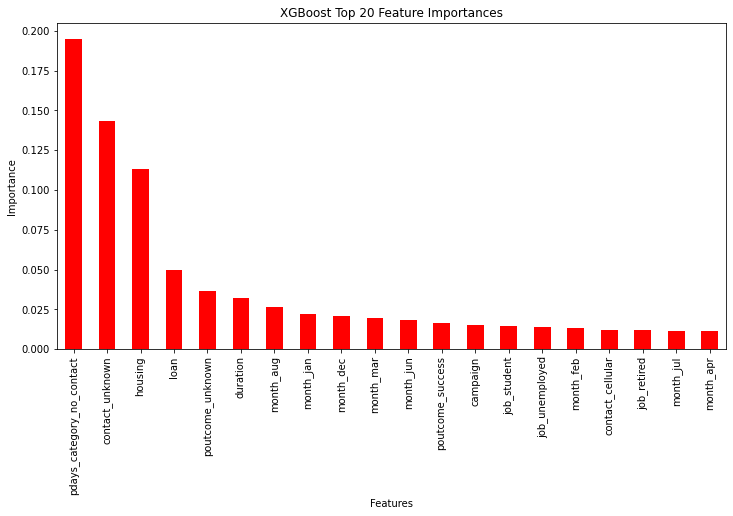

In [155]:
plt.figure(figsize=(12, 6))
xgb_top_features.plot(kind='bar', color='red')
plt.title("XGBoost Top 20 Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

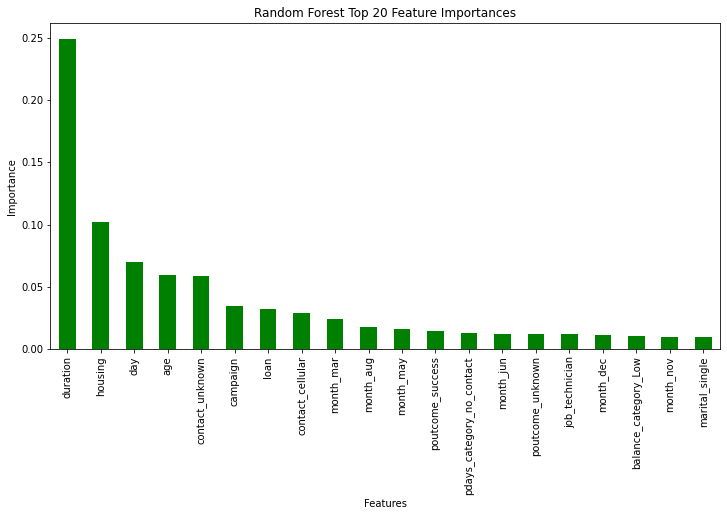

In [158]:
plt.figure(figsize=(12, 6))
rf_top_features.plot(kind='bar',color='green')
plt.title("Random Forest Top 20 Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

In [112]:
common_features = set(xgb_top_features.index) & set(rf_top_features.index)
print("\nCommon Important Features:")
print(common_features)


Common Important Features:
{'duration', 'month_dec', 'housing', 'pdays_category_no_contact', 'loan', 'month_mar', 'campaign', 'month_jun', 'poutcome_unknown', 'poutcome_success', 'contact_cellular', 'month_aug', 'contact_unknown'}
